In [1]:
from commons import *

# 1. A Direct Regressor
Here we try to build a global model for everything á la SMAC.

In [2]:
dfAtomic = pd.read_csv("data/runtimes/runtimes_atomic.csv")
dfAtomic = dfAtomic[dfAtomic["error"].isna()]

/home/felix/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dfPipelines = pd.read_csv("data/rawruntimes/pipelines.csv", delimiter=";")

In [3]:
def getPlainAlgorithmName(name):
    return name[(name.rfind(".")+1):].lower()

def getClassifierOptionDF(algo, options = None):
    if options is None:
        options = []
    return explodeAlgorithmOptions(pd.DataFrame([[algo, " ".join(options)]], columns=["algorithm", "algorithmoptions"])).drop(columns=["algorithm", "algorithmoptions"]).add_prefix(algo + "_")

def getPreprocessorOptionDF(algo, options = None):
    if options is None:
        options = ";"
    elif type(options) != str:
        raise Exception("Pre-processor options must be a string.")
    return explodeAlgorithmOptions(pd.DataFrame([[algo, options]], columns=["algorithm", "algorithmoptions"])).drop(columns=["algorithm", "algorithmoptions"]).add_prefix(algo + "_")


def getVectorialRepresentationofRuntimes(dfPipelines):
    
    #
    dfBasis = pd.DataFrame([], columns=["openmlid", "numinstances", "numattributes", "searcher", "searcheroptions", "evaluator", "evaluatoroptions", "baseclassifier", "baseclassifieroptions", "metaclassifier", "metaclassifieroptions", "fittime", "apptimeperkinstances", "exception"])
    for algo in algorithms + metalearners:
        if algo in classifiers or algo in metalearners:
            dfAlgo = getClassifierOptionDF(algo)
        if algo in preprocessors:
            dfAlgo = getPreprocessorOptionDF(algo)
        dfBasis = dfAlgo if dfBasis is None else pd.concat([dfBasis, dfAlgo], axis=0)
    dfBasis = dfBasis.drop(index=dfBasis.index)
    
    pbar = tqdm(total=len(dfPipelines))
    for i, row in dfPipelines.iterrows():
        setup = eval(row["setup"])
        pipelinedescription = setup["pipeline"]["instructions"][0]["arguments"]
        searcherClass = getPlainAlgorithmName(pipelinedescription[0])
        searcherParams = pipelinedescription[1]
        evaluatorClass = getPlainAlgorithmName(pipelinedescription[2])
        evaluatorParams = pipelinedescription[3]
        classifierClass = getPlainAlgorithmName(pipelinedescription[4])
        classifierParams = pipelinedescription[5]
        isMetaLearner = not classifierClass in classifiers
        if isMetaLearner:
            indexBaseLearnerDescriptionStart = classifierParams.index("-W")
            indexBaseLearnerDescriptionStop = (indexBaseLearnerDescriptionStart + classifierParams[indexBaseLearnerDescriptionStart:].index("--") + 1) if "--" in classifierParams[indexBaseLearnerDescriptionStart:] else len(classifierParams)
            #baseClassifierDescription = classifierParams[indexBaseLearnerDescriptionStart:indexBaseLearnerDescriptionStop]
            baseClassifierName = getPlainAlgorithmName(classifierParams[indexBaseLearnerDescriptionStart + 1])
            baseClassifierParams = classifierParams[indexBaseLearnerDescriptionStop:]
            metaClassifierName = classifierClass
            metaClassifierParams = classifierParams[:indexBaseLearnerDescriptionStart]
        else:
            baseClassifierName = classifierClass
            baseClassifierParams = classifierParams
            metaClassifierName = np.nan
            metaClassifierParams = []
            
        # compose a dataframe for this row
        dfRow = pd.DataFrame([[setup['openmlid'], setup['numinstances'], setup['numattributes'], searcherClass, " ".join(searcherParams), evaluatorClass, " ".join(evaluatorParams), baseClassifierName, " ".join(baseClassifierParams), metaClassifierName, " ".join(metaClassifierParams), row["traintimeinms"], 1000 * row["timeforpredictionsinms"] / row["predictedinstances"], row["exception"]]], columns=["openmlid", "numinstances", "numattributes", "searcher", "searcheroptions", "evaluator", "evaluatoroptions", "baseclassifier", "baseclassifieroptions", "metaclassifier", "metaclassifieroptions", "fittime", "apptimeperkinstances", "exception"])
        dfRow = pd.concat([dfRow, getClassifierOptionDF(baseClassifierName, baseClassifierParams)], axis=1)
        if (not searcherParams is None and len(searcherParams) > 0) or (not evaluatorParams is None and len(evaluatorParams) > 0):
            ppName = searcherClass + "_" + evaluatorClass
            ppOptions = " ".join(searcherParams) + ";" + " ".join(evaluatorParams)
            dfRow = pd.concat([dfRow, getPreprocessorOptionDF(ppName, ppOptions)], axis=1)
        
        if not metaClassifierParams is None and len(metaClassifierParams) > 0:
            dfRow = pd.concat([dfRow, getClassifierOptionDF(metaClassifierName, metaClassifierParams)], axis=1)
        
        dfBasis = pd.concat([dfBasis, dfRow])
        pbar.update(1)
    pbar.close()
        
    return dfBasis

In [6]:
compute_vectorial_representation_of_runtimes = False

# this takes LONG (can be up to 1d), avoid if not necessary to re-compute
if compute_vectorial_representation_of_runtimes:
    dfPipelinesConverted = getVectorialRepresentationofRuntimes(dfPipelines[(dfPipelines["traintimeinms"].notna()) | (dfPipelines["exception"].notna())])
    dfPipelinesConverted.to_csv("data/workdata/pipelines.csv", sep=";", index=False)
    dfPipelinesConverted

In [7]:
dfPipelines = pd.read_csv("data/workdata/pipelines.csv", sep=";")

In [10]:
dfPipelinesMod = dfPipelines.copy()
timeouts = (dfPipelines["exception"].notna()) & (dfPipelines["exception"].str.contains("Timeout"))
dfPipelinesMod.at[np.where(timeouts)[0], "fittime"] = 3600 * 1000

# 2. The Composed Regressor

In [11]:
class ComposedRegressor():
    
    def __init__(self, dfAtomic):
        self.dfAtomic = dfAtomic[["algorithm", "algorithmoptions", "openmlid", "fitsize", "fitattributes", "fittime", "applicationtimeperkinstances"]].copy()
        self.dfAtomic["msize"] = self.dfAtomic["fitsize"] * self.dfAtomic["fitattributes"]
        self.dfAtomic["msize2"] = self.dfAtomic["fitsize"] * self.dfAtomic["fitattributes"] ** 2
        
    def predictRuntime(self, openmlid, fitsize, fitattributes, appsize, baselearner, preprocessor=None, metalearner = None):
        
        hasPreprocessor = not preprocessor is None
        hasMetalearner = not metalearner is None
        
        # build relevant models
        models = {"base": {}, "pre": {}}
        for role, algorithm in [("base", baselearner), ("pre", preprocessor)]:
            if not algorithm is None:
                dfTrain = self.dfAtomic[(self.dfAtomic["openmlid"] != openmlid) & (self.dfAtomic["algorithm"] == algorithm[0])]
                if len(dfTrain) == 0:
                    raise Exception("No training examples for openmlid " + str(openmlid) + " and baselearner " + algorithm[0])
                X = explodeAlgorithmOptions(dfTrain[["algorithm", "algorithmoptions", "fitsize", "fitattributes"]]).drop(columns=["algorithm", "algorithmoptions"])
                for att in "searcheroptions", "evaloptions":
                    if att in list(X.columns):
                        X = X.drop(columns=[att])
                for target in ["fittime", "applicationtimeperkinstances"]:
                    model = sk.ensemble.RandomForestRegressor(n_estimators=10)
                    Y = dfTrain[target].values
                    #print(dfTrain["fittime"].values)
                    model.fit(X, Y)
                    models[role][target] = model
                    #print("Forest trained for " + role + " " + baselearner[0] + " " + target + " using " + str(len(X)) + " examples excluding those for dataset " + str(openmlid))
                
        # extract meta-features
        X = [fitsize, fitattributes]#, fitsize * fitattributes, fitsize * fitattributes ** 2]
        
        # get pre-processor runtime and estimate of modified data
        if hasPreprocessor:
            X_params_df = getPreprocessorOptionDF(preprocessor[0], preprocessor[1]).drop(columns=[preprocessor[0] + v for v in ["_searcheroptions", "_evaloptions"]])
            X_params = list(X_params_df.values[0])
            runtimePreprocessorFit = models["pre"]["fittime"].predict([X + X_params])[0]
            runtimePreprocessorApp = models["pre"]["applicationtimeperkinstances"].predict([X + X_params])[0] * (fitsize + appsize) / 1000
            runtimePreprocessor = runtimePreprocessorFit + runtimePreprocessorApp
            if preprocessor[0] + "_N" in list(X_params_df.columns):
                estimatedNumberOfNewAttributes = min(fitattributes, X_params_df[preprocessor[0] + "_N"].values[0])
            else:
                estimatedNumberOfNewAttributes = fitattributes
            X = [X[0], estimatedNumberOfNewAttributes]#, X[0] * estimatedNumberOfNewAttributes, X[0] * estimatedNumberOfNewAttributes**2]
        else:
            runtimePreprocessor = 0

        # if there is a meta-learner, compute dataset meta features for the used base learner
        if hasMetalearner:
            pass

        # get base learner runtimes
        #print("Predict: ", X, X_params)
        #print("original data: " + str(self.dfAtomic[(self.dfAtomic["openmlid"] != openmlid) & (self.dfAtomic["algorithm"] == algorithm[0]) & (self.dfAtomic["fitsize"] == X[0]) & (self.dfAtomic["fitattributes"] == X[1])]))
        X_params = list(getClassifierOptionDF(baselearner[0], baselearner[1].split(" ") if str(baselearner[1]) != "nan" else []).values[0])
        runtimeBaselearnerFit = models["base"]["fittime"].predict([X + X_params])[0]
        runtimeBaselearnerApp = models["base"]["applicationtimeperkinstances"].predict([X + X_params])[0]
        
        # consider meta-learner if relevant
        totalruntime = runtimePreprocessor
        if hasMetalearner:
            k, p, q = (1, 2, 3) # get params
            totalruntime += k * (runtimeBaselearnerFit + (p+q)/1000 * runtimeBaselearnerApp)
        else:
            #print(runtimePreprocessor, runtimeBaselearnerFit, runtimeBaselearnerApp)
            blruntime = runtimeBaselearnerFit + runtimeBaselearnerApp * (fitsize + appsize) / 1000
            totalruntime += blruntime
            print("PP: " + str(runtimePreprocessor) + ", BL: " + str(blruntime))
        return totalruntime

        
dfTest = pd.DataFrame([[100, 100, 1, 0, 1, 0, 0, 0, 0, 12000]], columns = ["fitsize", "fitattributes", 'D', 'Q_K2', 'Q_Tabu', 'Q_SA', 'Q_LAGDHC', 'Q_TAN', 'Q_HC', 'appsize'])
dfTest["af1"] = dfTest["fitsize"] * dfTest["fitattributes"]
dfTest["af2"] = dfTest["fitsize"] * dfTest["fitattributes"]**2
dfTest = dfTest[["fitsize", "fitattributes", "af1", "af2", 'D', 'Q_K2', 'Q_Tabu', 'Q_SA', 'Q_LAGDHC', 'Q_TAN', 'Q_HC', 'appsize']]

# 3. Compare the Models

In [ ]:
reg = ComposedRegressor(dfAtomic[(dfAtomic["algorithmoptions"].notna())])

COMPARISON = []
for (openmlid, fitsize, fitattributes), dfValidation in tqdm(dfPipelinesMod.groupby(["openmlid", "numinstances", "numattributes"])):


    dfVectorial = pd.get_dummies(dfPipelinesMod, columns=["searcher", "evaluator", "baseclassifier", "metaclassifier"]).drop(columns=["searcheroptions", "evaluatoroptions", "baseclassifieroptions", "metaclassifieroptions", "exception"])
    dfVectorial["fittime"] = dfVectorial["fittime"].fillna(3600000)
    dfVectorial["apptimeperkinstances"] = dfVectorial["apptimeperkinstances"].fillna(0)
    dfVectorial = dfVectorial.fillna(-1)
    for pp in preprocessors:
        dfVectorial = dfVectorial.drop(columns=[pp + "_searcheroptions", pp + "_evaloptions"])
    
    dfValidation = dfVectorial[(dfVectorial["openmlid"] == openmlid) & (dfVectorial["numinstances"] == fitsize) & (dfVectorial["numattributes"] == fitattributes)]
    print(len(dfValidation))
    
    # train vectorial model
    regVectorial = sk.ensemble.RandomForestRegressor(n_estimators=1)
    dfTrainBasis = dfVectorial[(dfVectorial["openmlid"] != openmlid) & (dfVectorial["numinstances"] != fitsize) & (dfVectorial["numattributes"] != fitattributes)]
    X_train = dfTrainBasis.drop(columns=["openmlid", "fittime", "apptimeperkinstances"])
    Y_train = dfTrainBasis["fittime"] + dfTrainBasis["apptimeperkinstances"]
    invalidIndices = np.isnan(Y_train)
    X_train = X_train[~invalidIndices]
    Y_train = Y_train[~invalidIndices]
    regVectorial.fit(X_train, Y_train)
    print("Training finished")
    
    for i, row in dfValidation.iterrows():
        
        origRow = dfPipelinesMod.iloc[i]
        if str(origRow["baseclassifier"]) in ["decisionstump", "kstar", "naivebayesmultinomial", "zeror"]:
            print(origRow["baseclassifier"])
            continue
        #if str(origRow["metaclassifier"]) != "nan": # ignore pipelines with meta-learner
            #print("meta")
            #continue
        
        if not np.isnan(row["fittime"]) and row["fittime"] > 10000:
            
            
            #print(origRow)
            #print(origRow["fittime"] + origRow["apptimeperkinstances"])
            
            # now make with the vectorial RF
            X_test = row.drop(labels=["openmlid", "fittime", "apptimeperkinstances"])
            Y_test = row["fittime"] + row["apptimeperkinstances"]
            Y_pred = regVectorial.predict([X_test])
            pred_error_rf = (Y_test - Y_pred)[0] / 1000
            
            if Y_test < 3600000:

                # now make with the composed model
                if str(origRow["searcher"]) != "nan":
                    preprocessor = (origRow["searcher"] + "_" + origRow["evaluator"], str(origRow["searcheroptions"]) + ";" + str(origRow["evaluatoroptions"] if str(origRow["evaluatoroptions"]) != "nan" else ""))
                else:
                    preprocessor = None
                #print(origRow["searcher"], preprocessor)
                F = reg.predictRuntime(origRow["openmlid"], origRow["numinstances"], origRow["numattributes"], 1000, baselearner=(origRow["baseclassifier"], origRow["baseclassifieroptions"]), preprocessor=preprocessor)
                A = Y_test
                pred_error_comp = (A - F) / 1000

                comp_here = [pred_error_rf, pred_error_comp]
                COMPARISON.append(comp_here)
                print(origRow["evaluator"], origRow["metaclassifier"], origRow["baseclassifier"], Y_test, Y_pred, "error rf:", pred_error_rf, "error comp:", pred_error_comp)
                #print(origRow["numinstances"], origRow["numattributes"], "truth:", int( / 1000), "prediction:", int(F / 1000))

33


In [14]:
dfComparison = pd.DataFrame(COMPARISON, columns=["rf", "comp"])

In [16]:
dfComparison.to_csv("data/results/pipelinecomparison.csv", index=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f11218afb50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f11218b4610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f11218af610>,
 'medians': [<matplotlib.lines.Line2D at 0x7f11218bc110>,
 'fliers': [],
 'means': []}

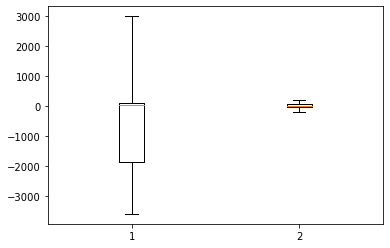

In [24]:
plt.boxplot(dfComparison.values, 0, '')

In [29]:
sp.stats.trim_mean(np.abs(dfComparison.values), 0.05, axis=0)

array([946.96321218, 178.01102781])